## Short demo
### Automatic graph downloading

In [1]:
# ###
# Make sure you have followed all the instructions in Readme.md
# ###

import logging
logging.basicConfig(format='%(name)s:%(levelname)s:%(message)s')
# logging.getLogger().setLevel(logging.INFO)

from graph_io import GraphCollections

# Graph name is searched in networkrepository namespace
g = GraphCollections.get(name='dolphins')
print(g.name, "V=%s, E=%s" % (g.nodes(), g.edges()))

# We can explicitly specify collection, whether to extract giant component, and some other flags
g = GraphCollections.get(name='soc-wiki-Vote', collection='netrepo', giant_only=True)
print(g.name, "V=%s, E=%s" % (g.nodes(), g.edges()))

ModuleNotFoundError: No module named 'graph_io'

### Statistics computation

In [2]:
from statistics import Stat
import os

# Once graph is downloaded, it will be loaded from file
g = GraphCollections.get(name='dolphins')

for stat in Stat:
    print("%s = %s" % (stat.short, g[stat]))
# Once statistics are computed, they are saved to file

# Statistics computation can be run from terminal, e.g.:
command ='python3 statistics.py -n soc-wiki-Vote -s DEGREE_DISTR BETWEENNESS_DISTR'
print(os.system(command))

n = 62
e = 159
avg-deg = 5.129032258064516
max-deg = 12
ass = -0.04359402880072594
avg-cc = 0.2589582460550202
wcc-max = 1.0
diam90 = 4.929457364341085
DegDistr = {9: 6, 4: 3, 10: 7, 6: 4, 7: 6, 11: 5, 1: 6, 3: 4, 14: 8, 15: 12, 16: 7, 17: 6, 18: 9, 2: 8, 19: 7, 20: 4, 8: 5, 21: 9, 22: 6, 23: 1, 25: 6, 26: 3, 27: 3, 28: 5, 29: 5, 30: 9, 31: 5, 32: 1, 33: 3, 34: 10, 13: 1, 35: 5, 36: 1, 37: 7, 24: 3, 38: 11, 39: 8, 40: 2, 41: 8, 42: 5, 43: 6, 44: 7, 45: 4, 46: 11, 47: 2, 48: 6, 50: 2, 51: 7, 52: 10, 5: 1, 12: 1, 53: 4, 54: 2, 55: 7, 56: 2, 57: 2, 58: 9, 49: 1, 59: 1, 60: 5, 61: 1, 62: 3}
BtwDistr = {1: 69.97578630536131, 2: 765.6194810250864, 3: 28.662806818181817, 4: 9.186387499999997, 5: 0.0, 6: 15.038621547619044, 7: 103.31198780735521, 8: 435.92775810884467, 9: 80.18220802834898, 10: 74.7499059765235, 11: 58.98393360389609, 12: 0.0, 13: 0.0, 14: 193.94242584348578, 15: 234.80154937761418, 16: 115.19162563131152, 17: 11.432223333333333, 18: 407.13606001760786, 19: 53.6815774544358, 2

### Visualize crawler

<IPython.core.display.Javascript object>


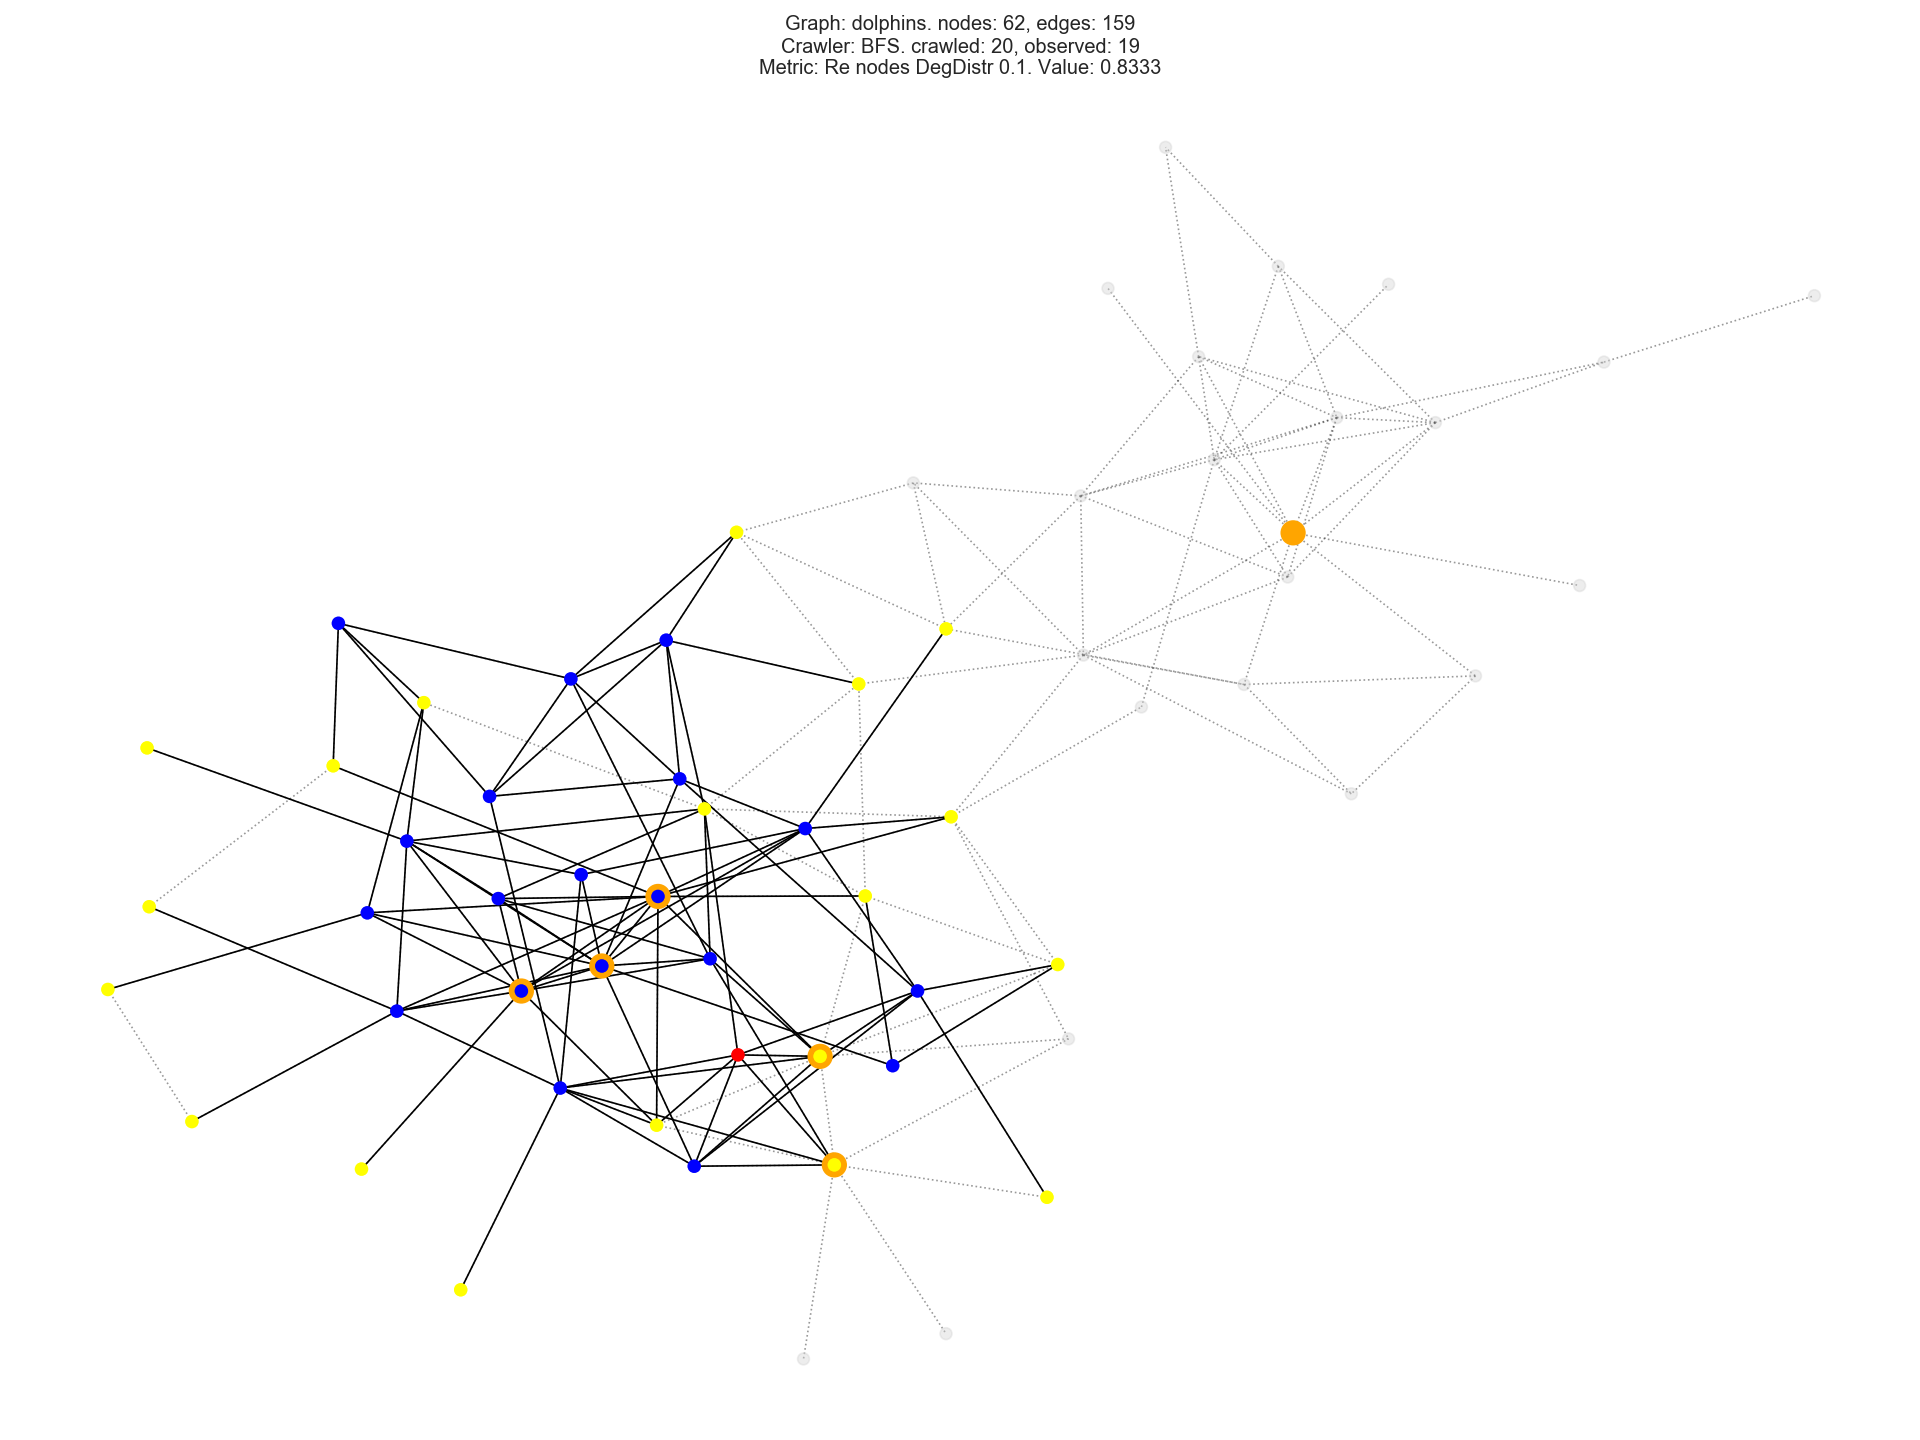

Running iterations:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
Making gif: 100%|██████████| 20/20 [00:00<00:00, 44.38it/s]


See pics at /home/misha/workspace/crawling/pics/visual/dolphins


In [3]:
%matplotlib notebook

from crawlers.cbasic import MaximumObservedDegreeCrawler, BreadthFirstSearchCrawler
from running.metrics_and_runner import TopCentralityMetric
from running.visual_runner import CrawlerVisualRunner
from statistics import Stat, get_top_centrality_nodes

g = GraphCollections.get('dolphins')

# Top-p nodes are the target
p = 0.1

# Define BFS crawler with its parameters
crawler_def = (BreadthFirstSearchCrawler, {'initial_seed': 1})
# Define recall metric with its parameters
metric_def = (TopCentralityMetric, {'top': p, 'centrality': Stat.DEGREE_DISTR.short, 'measure': 'Re', 'part': 'nodes'})
# Target set is top-p degree nodes
target_set = get_top_centrality_nodes(g, Stat.DEGREE_DISTR, count=int(p*g.nodes()))

# Create visualizer for the graph which will make 20 crawling steps
cvr = CrawlerVisualRunner(g, crawler_def, metric_def, budget=20, step=1)
# Run visualizer. Picture for each step is saved to file
cvr.run(draw_orig=True, bold_edges=True, labels=False, make_gif=True, target_set=target_set)

print("See pics at", cvr._save_dir())

### Animated crawler runner

<IPython.core.display.Javascript object>


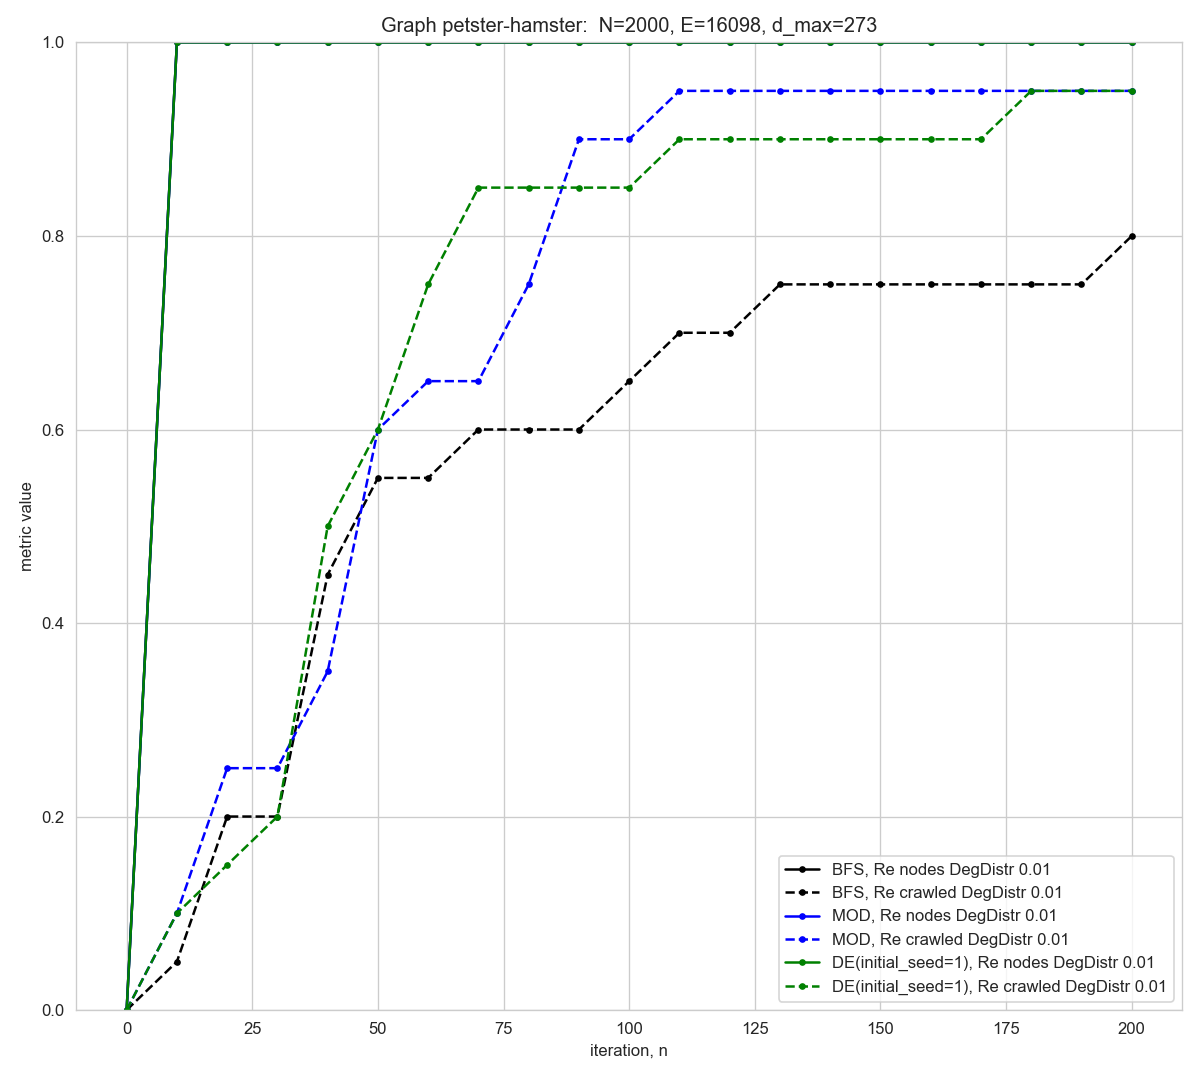

In [4]:
from crawlers.cbasic import MaximumObservedDegreeCrawler, BreadthFirstSearchCrawler
from crawlers.cadvanced import DE_Crawler
from running.animated_runner import AnimatedCrawlerRunner

g = GraphCollections.get('petster-hamster')
p = 0.01
crawler_defs = [
    (BreadthFirstSearchCrawler, {'initial_seed': 1}),
    (MaximumObservedDegreeCrawler, {'batch': 1, 'initial_seed': 1}),
    (DE_Crawler, {'initial_seed': 1}),
]
metric_defs = [
    (TopCentralityMetric, {'top': p, 'centrality': Stat.DEGREE_DISTR.short, 'measure': 'Re', 'part': 'nodes'}),
    (TopCentralityMetric, {'top': p, 'centrality': Stat.DEGREE_DISTR.short, 'measure': 'Re', 'part': 'crawled'}),
]

# Create runner which will dynamically visualize measurements
ci = AnimatedCrawlerRunner(g, crawler_defs, metric_defs, budget=200, step=10)
ci.run(ylims=(0, 1))


### Run series of experiments in parallel

In [15]:
from crawlers.cbasic import RandomWalkCrawler, RandomCrawler, MaximumObservedDegreeCrawler, \
    BreadthFirstSearchCrawler, DepthFirstSearchCrawler, SnowBallCrawler
from crawlers.cadvanced import DE_Crawler
from crawlers.multiseed import MultiInstanceCrawler
from running.history_runner import CrawlerHistoryRunner

# Define several crawler configurations
crawler_defs = [
    (RandomWalkCrawler, {}),
    (RandomCrawler, {}),
    (BreadthFirstSearchCrawler, {}),
    (DepthFirstSearchCrawler, {}),
    (SnowBallCrawler, {'p': 0.1}),
    (MaximumObservedDegreeCrawler, {'batch': 1}),
    (MaximumObservedDegreeCrawler, {'batch': 10}),
    (DE_Crawler, {}),
    (MultiInstanceCrawler, {'count': 5, 'crawler_def': (MaximumObservedDegreeCrawler, {})}),
]

p = 0.01
# Define recall metrics corresponding 6 node centralities
metric_defs = [
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.DEGREE_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.PAGERANK_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.BETWEENNESS_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.ECCENTRICITY_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.CLOSENESS_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.K_CORENESS_DISTR.short}),
]

# Set the number of random seeds to start from
n_instances = 8
# Run crawling for several graphs
graph_names = ['petster-hamster', 'soc-wiki-Vote']
for graph_name in graph_names:
    g = GraphCollections.get(graph_name)
    # Create runner which will save measurements history to file
    chr = CrawlerHistoryRunner(g, crawler_defs, metric_defs)
    # Run with limitations on the number concurrent processes and the amount of memory
    chr.run_parallel_adaptive(n_instances, max_cpus=8, max_memory=30)
    print('\n\n')


Running iterations: 100%|██████████| 2000/2000 [00:00<00:00, 4269.41it/s]

Running iterations: 100%|██████████| 2000/2000 [00:00<00:00, 3410.75it/s]

Running iterations: 100%|██████████| 2000/2000 [00:00<00:00, 3468.82it/s]

Saving history: 100%|██████████| 9/9 [00:00<00:00, 226.29it/s]

Saving history: 100%|██████████| 9/9 [00:00<00:00, 335.06it/s]

Saving history: 100%|██████████| 9/9 [00:00<00:00, 249.64it/s]



Running iterations: 100%|██████████| 889/889 [00:00<00:00, 6944.79it/s]

Running iterations: 100%|██████████| 889/889 [00:00<00:00, 10198.70it/s]

Running iterations: 100%|██████████| 889/889 [00:00<00:00, 6518.76it/s]

Running iterations: 100%|██████████| 889/889 [00:00<00:00, 10218.18it/s]

Saving history: 100%|██████████| 9/9 [00:00<00:00, 202.35it/s]

Saving history: 100%|██████████| 9/9 [00:00<00:00, 377.39it/s]

Saving history: 100%|██████████| 9/9 [00:00<00:00, 595.13it/s]


### Run missing configurations

In [16]:
# Define some new configuration
crawler_defs = [
    (SnowBallCrawler, {'p': 0.5}),
    (DE_Crawler, {}),
]
p = 0.01
metric_defs = [
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.DEGREE_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.PAGERANK_DISTR.short}),
]

# If some of the combinations were already computed earlier, we can run only missing ones.
graph_names = ['petster-hamster', 'soc-wiki-Vote']
for graph_name in graph_names:
    g = GraphCollections.get(graph_name)
    # Create runner which will save measurements history to file
    chr = CrawlerHistoryRunner(g, crawler_defs, metric_defs)
    # Run missing with limitations on the number concurrent processes and the amount of memory
    chr.run_missing(n_instances, max_cpus=8, max_memory=30)



Reading history: 100%|██████████| 4/4 [00:00<00:00, 1063.33it/s]

Running iterations: 100%|██████████| 2000/2000 [00:00<00:00, 126473.50it/s]

Running iterations: 100%|██████████| 2000/2000 [00:00<00:00, 115494.66it/s]

Running iterations: 100%|██████████| 2000/2000 [00:00<00:00, 148929.59it/s]

Running iterations: 100%|██████████| 2000/2000 [00:00<00:00, 82648.83it/s]

Saving history: 100%|██████████| 1/1 [00:00<00:00, 71.37it/s][A

Running iterations: 100%|██████████| 2000/2000 [00:00<00:00, 82259.00it/s]

Saving history: 100%|██████████| 1/1 [00:00<00:00, 191.88it/s]

Saving history: 100%|██████████| 1/1 [00:00<00:00, 147.94it/s]

Saving history: 100%|██████████| 1/1 [00:00<00:00, 565.27it/s]

Reading history: 100%|██████████| 4/4 [00:00<00:00, 688.86it/s]

Running iterations: 100%|██████████| 889/889 [00:00<00:00, 38168.29it/s]

Running iterations: 100%|██████████| 889/889 [00:00<00:00, 46644.19it/s]

Running iterations: 100%|██████████| 889/889 [00:00<00:00, 43154.17it/s]

Runnin

### Merge and visualize results of a series of experiments


Reading history: 100%|██████████| 54/54 [00:00<00:00, 796.98it/s]

Reading history: 100%|██████████| 54/54 [00:00<00:00, 961.42it/s]

Reading history: 100%|██████████| 108/108 [00:00<00:00, 903.41it/s][A


<IPython.core.display.Javascript object>


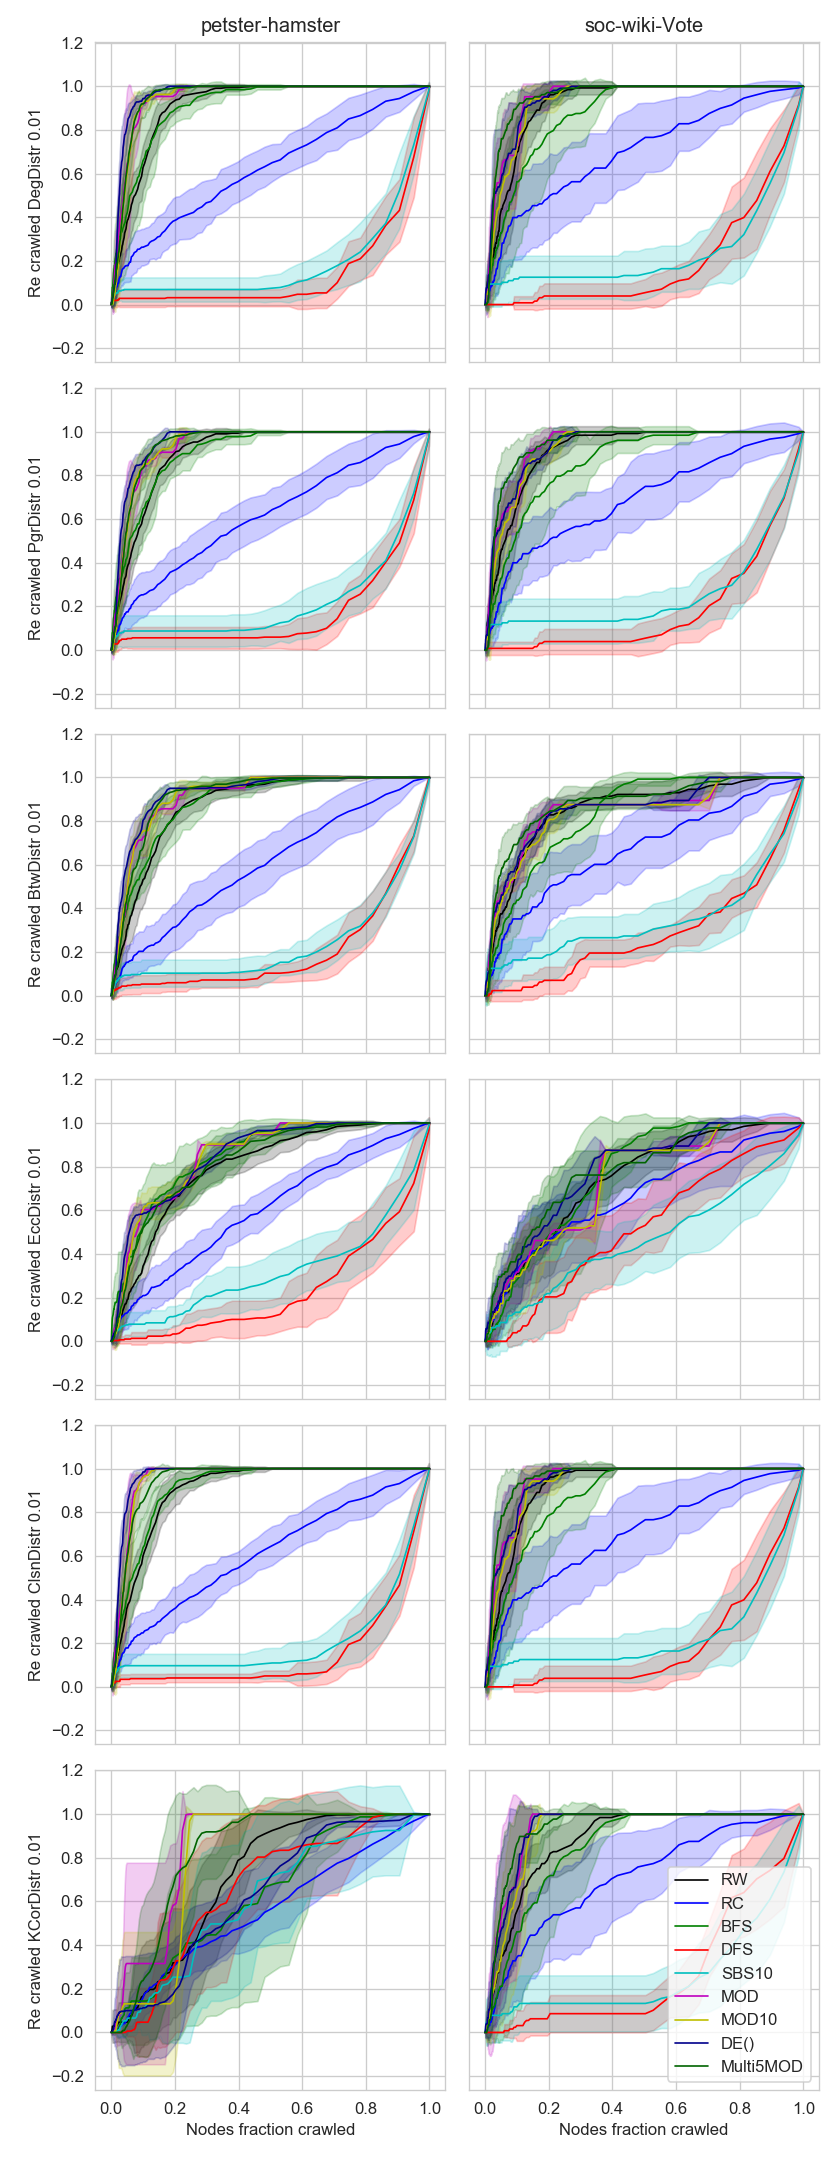


Plotting by crawler: 100%|██████████| 108/108 [00:00<00:00, 258.03it/s]

Computing AUCCs: 100%|██████████| 108/108 [00:00<00:00, 250.17it/s]


<IPython.core.display.Javascript object>


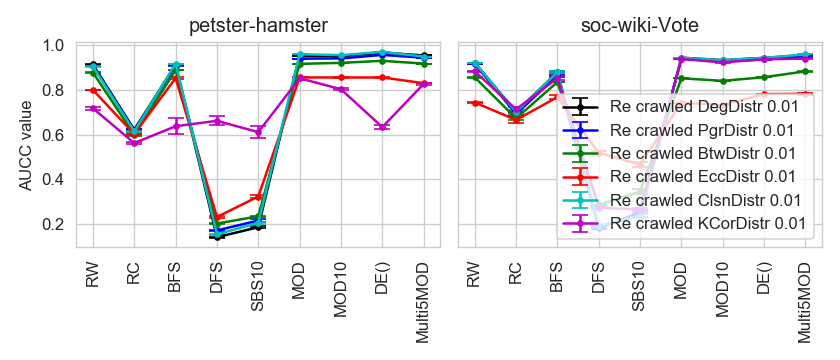


Plotting AUCC: 100%|██████████| 12/12 [00:00<00:00, 290.66it/s]


<IPython.core.display.Javascript object>


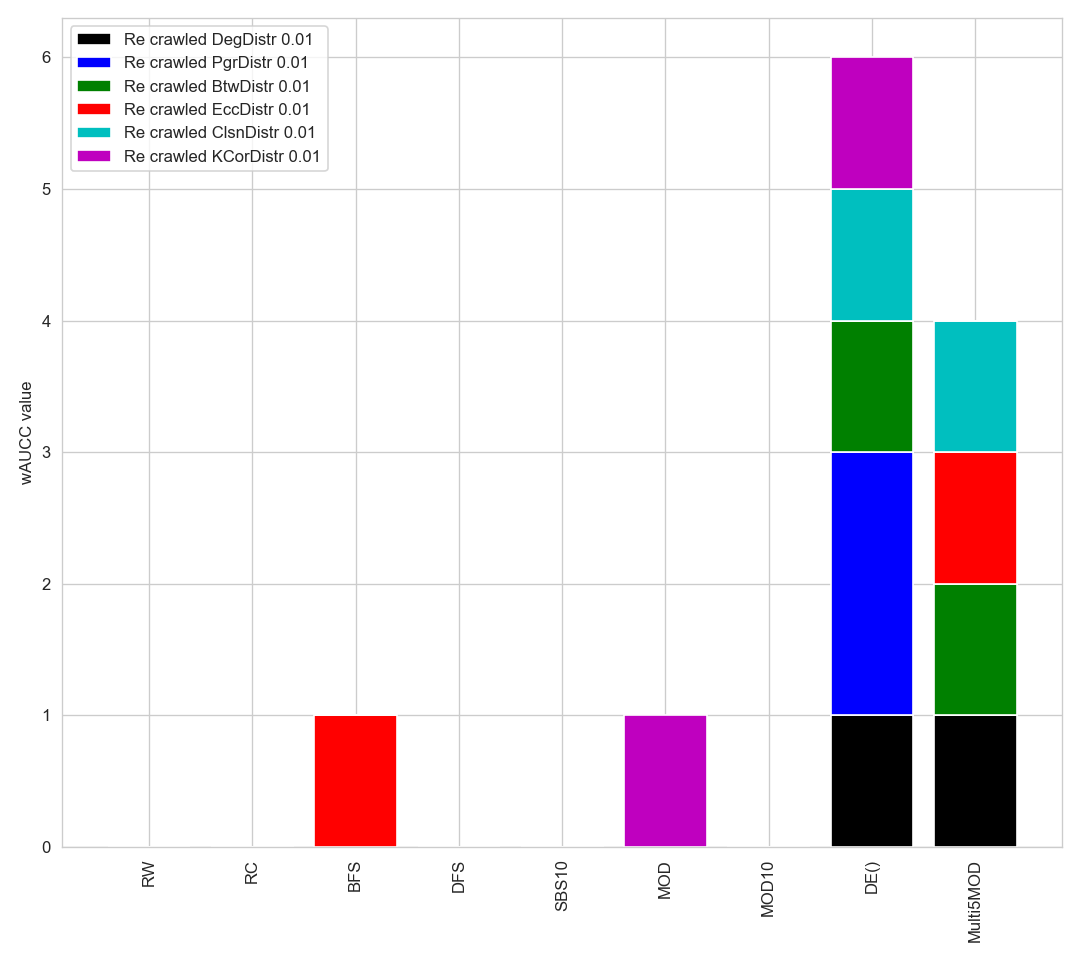

In [17]:
from running.merger import ResultsMerger

# Define again a wanted crawlers and metrics configuration
crawler_defs = [
    (RandomWalkCrawler, {}),
    (RandomCrawler, {}),
    (BreadthFirstSearchCrawler, {}),
    (DepthFirstSearchCrawler, {}),
    (SnowBallCrawler, {'p': 0.1}),
    (MaximumObservedDegreeCrawler, {'batch': 1}),
    (MaximumObservedDegreeCrawler, {'batch': 10}),
    (DE_Crawler, {}),
    (MultiInstanceCrawler, {'count': 5, 'crawler_def': (MaximumObservedDegreeCrawler, {})}),
]
p = 0.01
metric_defs = [
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.DEGREE_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.PAGERANK_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.BETWEENNESS_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.ECCENTRICITY_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.CLOSENESS_DISTR.short}),
    (TopCentralityMetric, {'top': p, 'measure': 'Re', 'part': 'crawled', 'centrality': Stat.K_CORENESS_DISTR.short}),
]
graph_names = ['petster-hamster', 'soc-wiki-Vote']
n_instances =8

# Run missing combination if any. It is useful when some runs of the initial configuration failed.
for graph_name in graph_names:
    g = GraphCollections.get(graph_name)
    chr = CrawlerHistoryRunner(g, crawler_defs, metric_defs)
    chr.run_missing(n_instances, max_cpus=8, max_memory=30)

# Create merger which can draw various plots
crm = ResultsMerger(graph_names, crawler_defs, metric_defs, n_instances=6)

# Draw crawler curves for each graph and each metric
crm.draw_by_crawler()

# Draw AUCC values for each graph and each metric
crm.draw_aucc('AUCC')

# Draw for each crawler weighted AUCC scores aggregated by all graphs and metrics
crm.draw_winners('wAUCC')

